In [1]:
import urllib.request
import zipfile
import os.path

C_DATA_DIRECTORY = "./data/"

def download_if_not_exists(url, save_name, directory=C_DATA_DIRECTORY):
    if not os.path.isdir(directory):
        os.mkdir(directory)
    directory = directory if directory.endswith("/") else directory + "/"
    if os.path.exists(directory + save_name):
        return
    print("Downloading %s as %s..." % (url, save_name))
    urllib.request.urlretrieve(url, directory + save_name)
    print("Downloaded %s" % save_name)


## Dane z GIOŚu

[Link](http://powietrze.gios.gov.pl/pjp/archives)

In [2]:
import openpyxl as xls
import pandas as pd
from itertools import islice

def load_metadata(filename):
    """
    Wczytuje dane stacji z pliku podpisanego jako "Metadane - stacje i stanowiska pomiarowe".
    Wiersze w pliku są ponumerowane i zawiera on jeden wiersz nagłówka.
    """
    workbook = xls.load_workbook(filename, read_only=True)
    ws = workbook.active
    data = ws.values
    cols = next(data)[1:] 
    data = list(data)
    idx = [r[0] for r in data]
    data = (r[1:] for r in data)
    return pd.DataFrame(data, index=idx, columns=cols)

In [3]:
import math

def collapse_row(row, col_names):
    """
    Sprawdza, czy wszystkie wartości w wierszu są takie same i zwraca te identyczną wartość.
    Pierwszy wpis traktowany jest jako nagłówek wiersza. Jeżeli któreś dane nie są równe, jest wypisywany warning.
    """
    val_name = row[0]
    val = row[1]
    for i in range(2, len(row)):
        if row[i] != val and False: # debug off
            print("Warning: column %s in row %s has unexpected value '%s'" % (col_names[i], val_name, str(row[i])))
    return val

def load_series(filename, header_version, selected_stations=None):
    """
    Wczytuje dane z pliku z pomiarami.
    """
    workbook = xls.load_workbook(filename, read_only=True)
    ws = workbook.active
    data = ws.values
    
    # Przetwarzanie nagłówka
    if header_version == 1:
        next(data) # pomiń wiersz z numerami kolumn
        codes = next(data)
        sensor_name = collapse_row(next(data), codes) # odczytaj mierzoną wielkość
        collapse_row(next(data), codes) # pomiń czas uśrednienia
        collapse_row(next(data), codes) # jednostka
        next(data) # pomiń kod stanowiska
    elif header_version == 2:
        codes = next(data)
        sensor_name = collapse_row(next(data), codes) # odczytaj mierzoną wielkość
        collapse_row(next(data), codes) # pomiń czas uśrednienia
    elif header_version == 3:
        next(data) # pomiń wiersz z numerami kolumn
        codes = next(data)
        sensor_name = collapse_row(next(data), codes) # odczytaj mierzoną wielkość
        collapse_row(next(data), codes) # pomiń czas uśrednienia
    else:
        raise ValueError("Invalid header version number")
        
    col_indices = []
    for s in selected_stations:
        i = 0
        for c in codes:
            if c == s["Kod stacji"] or c == s["Stary Kod stacji"]:
                col_indices.append((s["Kod stacji"], i))
                break
            i += 1
        else:
            col_indices.append((s["Kod stacji"], None))
    df_idx = []
    df_data = []
    
    # Właściwe dane
    for row in data:
        if row[0] is None:
            continue
        date = row[0].date()
        time = row[0].time()
        for (name, idx) in col_indices:
            df_idx.append((date, time, name))
            value = row[idx] if idx else math.nan
            if type(value) == str:
                value = float(value.replace(",", "."))
            df_data.append(value)
            
    index = pd.MultiIndex.from_tuples(df_idx)
    index.names = ["Data", "Godzina", "Kod Stacji"]
    return pd.Series(df_data, index=index)

In [4]:
download_if_not_exists(r"http://powietrze.gios.gov.pl/pjp/archives/downloadFile/327", "META_Stacje.xlsx")
meta = load_metadata(C_DATA_DIRECTORY + "META_Stacje.xlsx")

In [36]:
#stations = meta[meta["Miejscowość"] == "Warszawa"].to_dict("records")
stations = meta.to_dict("records")
years = [(2019, 322), (2018, 303), (2017, 262), (2016, 242), (2015, 236), (2014, 302), (2013, 234), (2012, 233), (2011, 232), (2010, 231)]
cumulative_data = pd.DataFrame()

def read_zipped_series(zf, old_header, filename):
    if filename not in zf.namelist():
        raise KeyError("ERROR: file %s not found" % filename)
    if not os.path.exists(C_DATA_DIRECTORY + filename):
        zf.extract(filename, C_DATA_DIRECTORY)
    print("Loading %s" % filename)
    return load_series(C_DATA_DIRECTORY + filename, old_header, selected_stations=stations)

# Wczytaj dane z zipów
for (year, fileid) in years:
    zip_name = "GIOS-%i.zip" % year
    download_if_not_exists("http://powietrze.gios.gov.pl/pjp/archives/downloadFile/%i" % fileid, zip_name)
    header = 1
    if year < 2016:
        header = 2
    
    with zipfile.ZipFile(C_DATA_DIRECTORY + zip_name, "r") as zf:
        year_data = pd.DataFrame()
        
        year_data["PM10"] = read_zipped_series(zf, header, "%i_PM10_24g.xlsx" % year).groupby(["Data", "Kod Stacji"]).mean()
        year_data["NOx"] = read_zipped_series(zf, 3 if year == 2012 else header, "%i_NOx_1g.xlsx" % year).groupby(["Data", "Kod Stacji"]).mean()
        year_data["CO"] = read_zipped_series(zf, header, "%i_CO_1g.xlsx" % year).groupby(["Data", "Kod Stacji"]).mean()
        
        if year == 2016 or year <= 2014: # nie–xD
            year_data["PM2.5"] = read_zipped_series(zf, header, "%i_PM2.5_24g.xlsx" % year).groupby(["Data", "Kod Stacji"]).mean()
        else:
            year_data["PM2.5"] = read_zipped_series(zf, header, "%i_PM25_24g.xlsx" % year).groupby(["Data", "Kod Stacji"]).mean()
            
    cumulative_data = cumulative_data.append(year_data.dropna(how="all"), verify_integrity=True)
    
cumulative_data.sort_index()

Loading 2019_PM10_24g.xlsx
Loading 2019_NOx_1g.xlsx
Loading 2019_CO_1g.xlsx
Loading 2019_PM25_24g.xlsx
Loading 2018_PM10_24g.xlsx
Loading 2018_NOx_1g.xlsx
Loading 2018_CO_1g.xlsx
Loading 2018_PM25_24g.xlsx
Loading 2017_PM10_24g.xlsx
Loading 2017_NOx_1g.xlsx
Loading 2017_CO_1g.xlsx
Loading 2017_PM25_24g.xlsx
Loading 2016_PM10_24g.xlsx
Loading 2016_NOx_1g.xlsx
Loading 2016_CO_1g.xlsx
Loading 2016_PM2.5_24g.xlsx
Loading 2015_PM10_24g.xlsx
Loading 2015_NOx_1g.xlsx
Loading 2015_CO_1g.xlsx
Loading 2015_PM25_24g.xlsx
Loading 2014_PM10_24g.xlsx
Loading 2014_NOx_1g.xlsx


/usr/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Loading 2014_CO_1g.xlsx
Loading 2014_PM2.5_24g.xlsx
Loading 2013_PM10_24g.xlsx
Loading 2013_NOx_1g.xlsx
Loading 2013_CO_1g.xlsx
Loading 2013_PM2.5_24g.xlsx
Loading 2012_PM10_24g.xlsx
Loading 2012_NOx_1g.xlsx
Loading 2012_CO_1g.xlsx
Loading 2012_PM2.5_24g.xlsx
Loading 2011_PM10_24g.xlsx
Loading 2011_NOx_1g.xlsx
Loading 2011_CO_1g.xlsx
Loading 2011_PM2.5_24g.xlsx
Loading 2010_PM10_24g.xlsx
Loading 2010_NOx_1g.xlsx
Loading 2010_CO_1g.xlsx
Loading 2010_PM2.5_24g.xlsx


PM10        NOx        CO  PM2.5
Data       Kod Stacji                                         
2010-01-01 DsBogChop           NaN  16.913043       NaN    NaN
           DsCzerStraza      25.00  13.434783       NaN    NaN
           DsDzialoszyn      34.00  17.000000       NaN    NaN
           DsDziePilsud        NaN  16.130435       NaN    NaN
           DsGlogSikor         NaN  15.095652  0.429478    NaN
...                            ...        ...       ...    ...
2019-12-31 ZpSzczBudzWosMOB  18.36  14.090960       NaN    NaN
           ZpSzczPils02      24.13  21.762533       NaN    NaN
           ZpSzczec1Maj      15.42        NaN       NaN   6.52
           ZpSzczecPrze      14.33   8.912099       NaN    NaN
           ZpWiduBulRyb        NaN   7.640242       NaN    NaN

[842169 rows x 4 columns]

In [39]:
# Dopisz współrzędne
import numpy as np

stat_loc = dict()
for s in stations:
    stat_loc[s["Kod stacji"]] = str(s["WGS84 λ E"]) + "E", str(s["WGS84 φ N"]) + "N"
cumulative_data["Longitude"] = list(stat_loc[s[1]][0] for s in cumulative_data.index.values)
cumulative_data["Latitude"] = list(stat_loc[s[1]][1] for s in cumulative_data.index.values)
cumulative_data.head()

PM10        NOx  CO  PM2.5   Longitude    Latitude
Data       Kod Stacji                                                       
2019-01-01 DsDusznikMOB    NaN   8.987775 NaN    NaN  16.393319E  50.402645N
           DsDzialoszyn    NaN   5.425444 NaN    NaN  14.941319E  50.972167N
           DsDziePilsud    NaN  14.609665 NaN    NaN  16.648050E  50.732817N
           DsGlogWiStwo  13.71        NaN NaN    NaN  16.097822E  51.657022N
           DsJaworMOB    13.15   5.766020 NaN    NaN  16.202317E  51.049212N

In [41]:
cumulative_data.sort_index()
cumulative_data.to_csv("GIOS.csv")
cumulative_data.head()

PM10        NOx  CO  PM2.5   Longitude    Latitude
Data       Kod Stacji                                                       
2019-01-01 DsDusznikMOB    NaN   8.987775 NaN    NaN  16.393319E  50.402645N
           DsDzialoszyn    NaN   5.425444 NaN    NaN  14.941319E  50.972167N
           DsDziePilsud    NaN  14.609665 NaN    NaN  16.648050E  50.732817N
           DsGlogWiStwo  13.71        NaN NaN    NaN  16.097822E  51.657022N
           DsJaworMOB    13.15   5.766020 NaN    NaN  16.202317E  51.049212N

In [30]:
cumulative_data

PM10       NOx        CO  PM2.5
Data       Kod Stacji                                         
2019-01-01 MzWarAKrzywWSSE      NaN       NaN       NaN    NaN
           MzWarAKrzywo       23.77       NaN       NaN    NaN
           MzWarAlNiepo         NaN  52.70000  0.497826    NaN
           MzWarBajkowa         NaN       NaN       NaN    NaN
           MzWarChrosci         NaN  20.33913       NaN    NaN
...                             ...       ...       ...    ...
2019-12-31 MzWarszLazurowa      NaN       NaN       NaN    NaN
           MzWarszOskLanWSSE    NaN       NaN       NaN    NaN
           MzWarszSGGW          NaN       NaN       NaN    NaN
           MzWarszSuwalWSSE     NaN       NaN       NaN    NaN
           MzWarszZelazWSSE     NaN       NaN       NaN    NaN

[9855 rows x 4 columns]

## Podział na obszary

In [2]:
from geographiclib.geodesic import Geodesic
import json

In [64]:
WARSAW = (52.229676, 21.012229)
R1 = 10_000
R2 = 100_000
def region_of(station):
    geodesic = Geodesic.WGS84.Inverse(WARSAW[0], WARSAW[1], station["gegrLat"], station["gegrLon"])
    dist = geodesic["s12"]
    if dist <= R1:
        return "Warsaw"
    if dist > R2:
        return None
    azi = geodesic["azi1"]
    if -45.0 < azi <= 45.0:
        return "North"
    if 45.0 < azi <= 135.0:
        return "East"
    if -135.0 < azi <= -45.0:
        return "West"
    return "South"

In [65]:
with open("stations-all.json") as f:
    stations_in_api = json.load(f)
regions = {"Warsaw": [], "North": [], "East": [], "South": [], "West": []}
for station in stations_in_api:
    station["gegrLat"] = float(station["gegrLat"])
    station["gegrLon"] = float(station["gegrLon"])
    reg = region_of(station)
    if not reg:
        continue
    regions[reg].append(station)

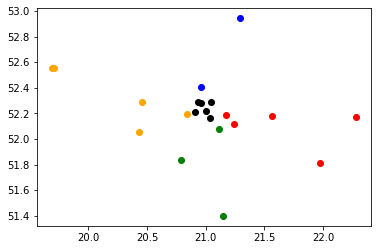

In [66]:
import matplotlib.pyplot as plt

ys = lambda sec: [s["gegrLat"] for s in regions[sec]]
xs = lambda sec: [s["gegrLon"] for s in regions[sec]]
for reg, col in [("Warsaw", "black"), ("North", "blue"), ("West", "orange"), ("South", "green"), ("East", "red")]:
    plt.scatter(xs(reg), ys(reg), color=col)

In [69]:
export = {}
for name, stations in regions.items():
    export[name] = [s["id"] for s in stations]
export["Warsaw"] = [530] # tylko aleja niepodległości
json.dumps(export)

'{"Warsaw": [530, 531, 538, 550, 552, 10955], "North": [9913, 471], "East": [10974, 10956, 485, 517, 248], "South": [10434, 515, 460], "West": [562, 497, 501, 466, 488], "WARSAW": [530]}'

In [68]:
for s in stations_in_api:
    if s["city"]["name"] == "Warszawa":
        print("%i %s (%f, %f)" % (s["id"], s["stationName"], s["gegrLon"], s["gegrLat"]))

530 Warszawa-Komunikacyjna (21.004724, 52.219298)
531 Warszawa-Podleśna (20.962156, 52.280939)
538 Warszawa-Tołstoja (20.933018, 52.285073)
550 Warszawa-Ursynów (21.033819, 52.160772)
552 Warszawa-Targówek (21.042458, 52.290864)
10955 Warszawa-Chrościckiego (20.906073, 52.207742)
10956 Warszawa-Bajkowa (21.176233, 52.188474)
